In [1]:
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
#Importing the necessesary libraries to run the code.

import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import numpy as np
from fastai.imports import *
from fastai.tabular import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier,GradientBoostingClassifier, ExtraTreesClassifier
from IPython.display import display
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import pylab as plot

In [3]:
data = pd.read_csv("titanic.csv")

In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
#Creating the test data from the Titanic data set with 418 rows and 11 columns
#Since we would want to predict the survived column, we drop it fron the original dataset.
test = data.drop("Survived", axis=1)
test = test.sample(418)
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
682,683,3,"Olsvigen, Mr. Thor Anderson",male,20.0,0,0,6563,9.2250,NaN,S
636,637,3,"Leinonen, Mr. Antti Gustaf",male,32.0,0,0,STON/O 2. 3101292,7.9250,NaN,S
747,748,2,"Sinkkonen, Miss. Anna",female,30.0,0,0,250648,13.0000,NaN,S
111,112,3,"Zabour, Miss. Hileni",female,14.5,1,0,2665,14.4542,NaN,C
823,824,3,"Moor, Mrs. (Beila)",female,27.0,0,1,392096,12.4750,E121,S


In [6]:
#checking the shape of the train data(data) and test data(test)
test.shape , data.shape

((418, 11), (891, 12))

#### Exploring the data.

In [7]:
#Here the we get the portion of the ones who died using the data of those who survived.

data['Died']= 1 - data['Survived']

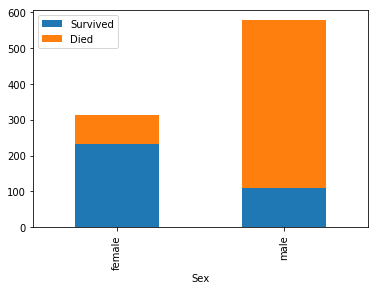

In [8]:
#From the graph male passengers died more than female.
data.groupby('Sex').agg('sum')[['Survived','Died']].plot(kind='bar',stacked=True)

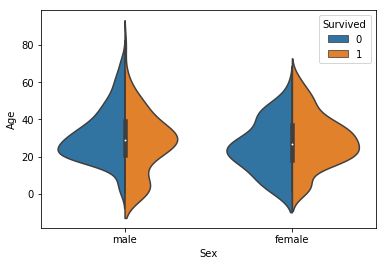

In [11]:
#From the graph below women survived more than men. 
sns.violinplot(x='Sex', y='Age', hue='Survived',data=data,split=True)

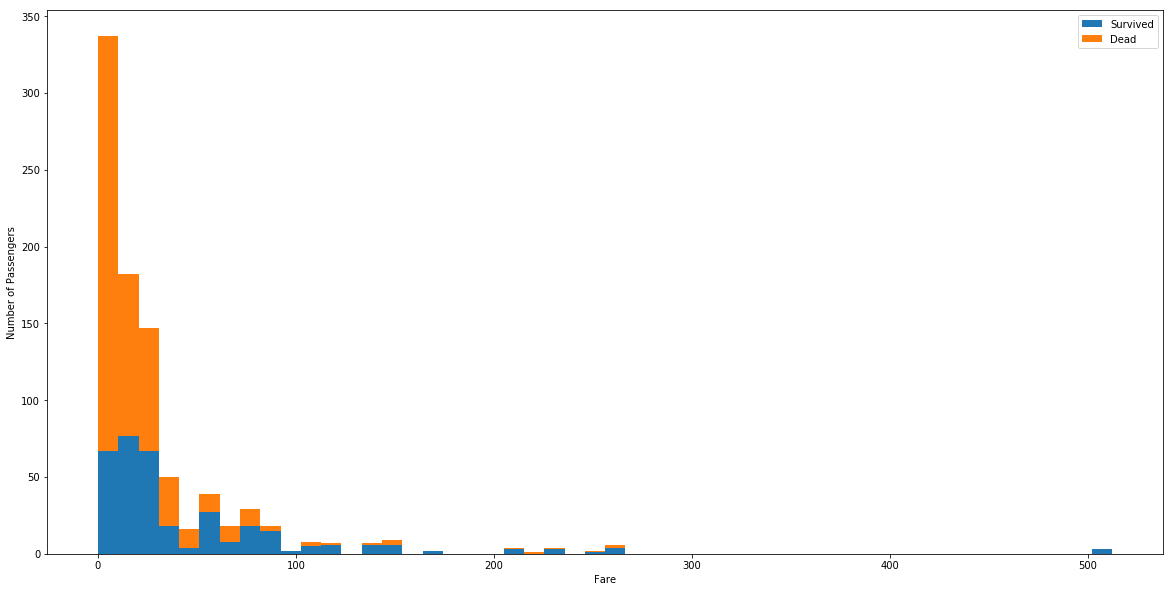

In [10]:
#Next we want to see if the Fare of each passenger impacted if they survived or died.
figure = plt.figure(figsize=(20,10))
plt.hist([data[data['Survived'] == 1]['Fare'], data[data['Survived'] == 0]['Fare']], 
         stacked=True,
         bins = 50, label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of Passengers')
plt.legend();

#From the graph, those who paid less for their tickets were more likely to die

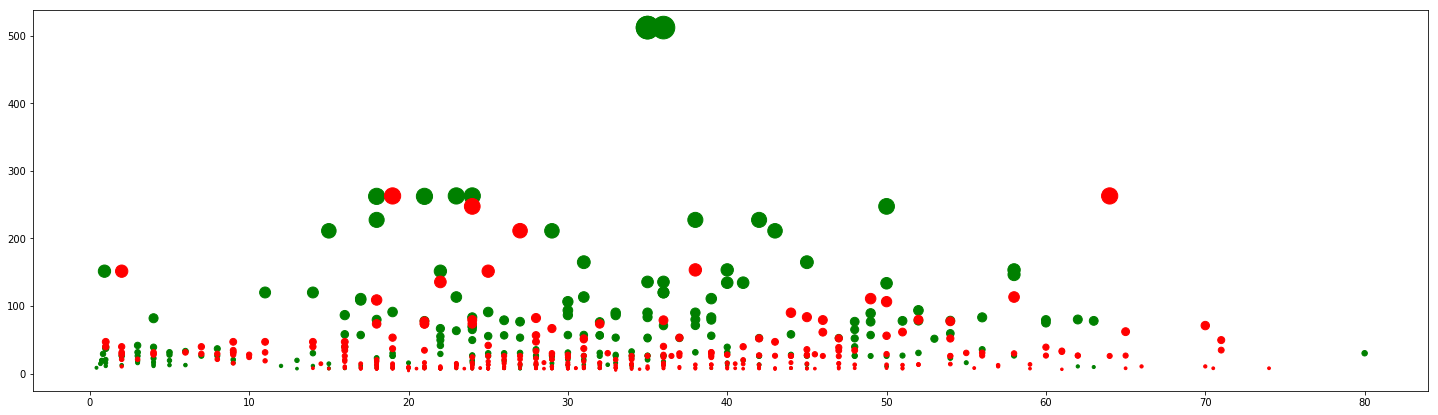

In [12]:
#we want to check how a combination of a passenger's age and fare impact their survival
#Size of the circles is proportional to the ticket fare. 
#X-axis = Age, Y-axis = Ticket_Fare 
#Green = Survived,Red = Died
#Small green dots between x=0 & x=7 : Children who were saved 
#Small red dots between x=10 & x=45 : Adults from a lower classes who died 
#Large green dots between x=20 & x=45 : Adults with larger ticket fares who survived

plt.figure(figsize=(25, 7))
ax = plt.subplot()

ax.scatter(data[data['Survived'] == 1]['Age'], data[data['Survived'] == 1]['Fare'], 
           c='green', s=data[data['Survived'] == 1]['Fare'])
ax.scatter(data[data['Survived'] == 0]['Age'], data[data['Survived'] == 0]['Fare'], 
           c='red', s=data[data['Survived'] == 0]['Fare']);

Text(0, 0.5, 'Average fare')

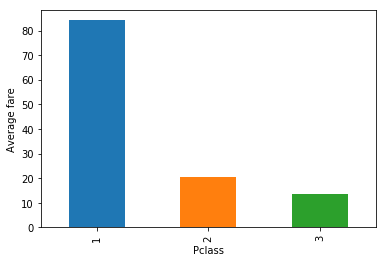

In [13]:
#Here we compare how passengers in different would pay for their fare
ax = plt.subplot()
ax.set_ylabel('Average fare')
data.groupby('Pclass').mean()['Fare'].plot(kind='bar',ax=ax)

### Feature Engineering

In [14]:
#So we first drop the column not needed 
#Then we combine the train and test data that is to be used in modelling the classifier.

x_train = data.drop(['Survived'], axis = 1)
x_train = data.drop(['Died'], axis = 1)
y_train = data['Survived']
x_test = test

In [15]:
data_combined = x_train.append(x_test,sort = True)
data_combined = data_combined.drop(['Survived'], axis = 1)
data_combined.shape

(1309, 11)

In [16]:
#This function will be used to display the new table after adding the test data.

def display_all(data):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(data)

In [17]:
#The code will display the last 5 instances in the combined dataset.
#the .T will change how the data will appear i.e the rows become the columns and the columns become the rows 
display_all(data_combined.tail().T)

,2,207,205,659,28
Age,26,26,2,58,NaN
Cabin,NaN,NaN,G6,D48,NaN
Embarked,S,C,S,C,Q
Fare,7.925,18.7875,10.4625,113.275,7.8792
Name,"Heikkinen, Miss. Laina","Albimona, Mr. Nassef Cassem","Strom, Miss. Telma Matilda","Newell, Mr. Arthur Webster","O'Dwyer, Miss. Ellen ""Nellie"""
Parch,0,0,1,2,0
PassengerId,3,208,206,660,29
Pclass,3,3,3,1,3
Sex,female,male,female,male,female
SibSp,0,0,0,0,0


#### The next functions are defined in Fastai v0.7.0 that are relevant to run the code. 

In [18]:
#This function converts strings to categorical values in a dataset
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

In [19]:
train_cats(data_combined)
data_combined

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Ticket
0,22.00,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,A/5 21171
1,38.00,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,PC 17599
2,26.00,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,STON/O2. 3101282
3,35.00,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,113803
4,35.00,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,373450
5,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,330877
6,54.00,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,17463
7,2.00,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,349909
8,27.00,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,347742
9,14.00,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,237736


In [20]:
#This function helps check the percentage of missing data in each column
display_all(data_combined.isnull().sum().sort_index()/len(data_combined))

Age            0.202445
Cabin          0.769290
Embarked       0.003056
Fare           0.000000
Name           0.000000
Parch          0.000000
PassengerId    0.000000
Pclass         0.000000
Sex            0.000000
SibSp          0.000000
Ticket         0.000000
dtype: float64

In [21]:
#It fills in the missing data in a column of a dataset with the median.
#It creates a column which states if the data for that instance was missing
def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

In [22]:
#This function changes a column into categories according to what was defined to its integer codes
def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1

In [23]:
#This function takes the dataset and splits it into X and Y(To be determined).
#It then converts the whole dataframe into numeric values for all columns.
#Any columns that are not to be converted are defined under skip_flds.
#Any columns to be ignored are defined under ignore_flds
#Any column with null values(na), the replacement is the median value of the column.
#The output of this function i will not have because we split the y in  In[14] and In[18]

def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

In [24]:
df_combined,y,nas = proc_df(data_combined,y_fld=None,ignore_flds=['Age','Name','Embarked','Cabin','Parch',
                                                      'SibSp'])
df_combined.head()

,Age,Name,Embarked,Cabin,Parch,SibSp,Fare,PassengerId,Pclass,Sex,Ticket
0,22.0,"Braund, Mr. Owen Harris",S,NaN,0,1,7.2500,1,3,2,524
1,38.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",C,C85,0,1,71.2833,2,1,1,597
2,26.0,"Heikkinen, Miss. Laina",S,NaN,0,0,7.9250,3,3,1,670
3,35.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",S,C123,0,1,53.1000,4,1,1,50
4,35.0,"Allen, Mr. William Henry",S,NaN,0,0,8.0500,5,3,2,473


## Processing Columns

#### Processing the column Family

In [25]:
#This function is used to add another feature to that describes a family size whichwill include
#The Parent-Child, Sibling-Spouse and the passenger.
#After getting the size of the family on board the value can be used to determine if the family is
#is a singleton family, a small family or a large family.

def process_family():
    
    global df
    # introducing a new feature : the size of families (including the passenger)
    df['FamilySize'] = df['Parch'] + df['SibSp'] + 1
    
    # introducing other features based on the family size
    df['Singleton'] = df['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    df['SmallFamily'] = df['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
    df['LargeFamily'] = df['FamilySize'].map(lambda s: 1 if 5 <= s else 0)    
    return df

In [26]:
# we then pass the data frame to the function
df = df_combined 
df_combined = process_family()

#### Processing the column Embarked

In [27]:
#This function will fill all missing values in column embarked with the value 'S'
#A one-hot encoding is then performed on the column embarked for values that only had 'S'
#This means that if one mebarked on 'S', it is 1 otherwise 0.
#the column Embarked is then dropped and replaced by the one-hot encoded column

def process_embarked():
    global df
    # two missing embarked values - filling them with the most frequent one in the train  set(S)
    df.Embarked.fillna('S', inplace=True)
    # dummy encoding 
    df_dummies = pd.get_dummies(df['Embarked'], prefix='Embarked')
    df = pd.concat([df, df_dummies], axis=1)
    df.drop('Embarked', axis=1, inplace=True)
#     status('embarked')
    return df

In [28]:
df_combined = process_embarked()

#### Processing the column Cabin

In [29]:
#This function fill all missing values in column Cabin with 'T' for unknown
#Then each value in the column is mapped to its cabin letter creating multiple columns for cabin each for each cabin letter.
#A one-hot encoding is then perfomed for each new column created for cabin letters.
#this means that if i was in cabin G the the value in column cabin_G is 1 and the rest 0

def process_cabin():
    global df    
    # replacing missing cabins with T (for Uknown)
    df.Cabin.fillna('T', inplace=True)
    
    # mapping each Cabin value with the cabin letter
    df['Cabin'] = df['Cabin'].map(lambda c: c[0])
    
    # dummy encoding ...
    cabin_dummies = pd.get_dummies(df['Cabin'], prefix='Cabin')    
    df = pd.concat([df, cabin_dummies], axis=1)

    df.drop('Cabin', axis=1, inplace=True)
#     status('cabin')
    return df

In [30]:
df_combined = process_cabin()

#### Processing the name to get the title from it.

In [31]:
#Here we take the column Name and split it into Title and Name using a comma or a fullstop.
titles = set()
for name in df['Name']:
    titles.add(name.split(',')[1].split('.')[0].strip())

In [32]:
#we then create a dictionary of the titles.
#After which we extract the titles from the names.
#After that wemap each title to its equivalent on the dictionary created

Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

def get_titles():
    # we extract the title from each name
    df['Title'] = df['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    
    # a map of more aggregated title
    # we map each title
    df['Title'] = df.Title.map(Title_Dictionary)
#     status('Title')
    return df

In [33]:
df = get_titles()
df.head()

,Age,Name,Parch,SibSp,Fare,PassengerId,Pclass,Sex,Ticket,FamilySize,...,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Title
0,22.0,"Braund, Mr. Owen Harris",0,1,7.2500,1,3,2,524,2,...,1,0,0,0,0,0,0,0,1,Mr
1,38.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,71.2833,2,1,1,597,2,...,0,0,0,1,0,0,0,0,0,Mrs
2,26.0,"Heikkinen, Miss. Laina",0,0,7.9250,3,3,1,670,1,...,1,0,0,0,0,0,0,0,1,Miss
3,35.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,53.1000,4,1,1,50,2,...,1,0,0,1,0,0,0,0,0,Mrs
4,35.0,"Allen, Mr. William Henry",0,0,8.0500,5,3,2,473,1,...,1,0,0,0,0,0,0,0,1,Mr


#### Processing the column Age

In [34]:
#Here we group Age,Sex, Title and Passenger Class as a group.
#This will help in making better predictions with a combination of a few features rather than one.
#summarize the Age grouped by sex, class and title
grouped_train = df.groupby(['Sex','Pclass','Title'])
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]

In [35]:
grouped_median_train.head()

,Sex,Pclass,Title,Age
0,1,1,Miss,29.5
1,1,1,Mrs,39.5
2,1,1,Officer,49.0
3,1,1,Royalty,33.0
4,1,2,Miss,22.5


In [36]:
df.head()

,Age,Name,Parch,SibSp,Fare,PassengerId,Pclass,Sex,Ticket,FamilySize,...,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Title
0,22.0,"Braund, Mr. Owen Harris",0,1,7.2500,1,3,2,524,2,...,1,0,0,0,0,0,0,0,1,Mr
1,38.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,71.2833,2,1,1,597,2,...,0,0,0,1,0,0,0,0,0,Mrs
2,26.0,"Heikkinen, Miss. Laina",0,0,7.9250,3,3,1,670,1,...,1,0,0,0,0,0,0,0,1,Miss
3,35.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,53.1000,4,1,1,50,2,...,1,0,0,1,0,0,0,0,0,Mrs
4,35.0,"Allen, Mr. William Henry",0,0,8.0500,5,3,2,473,1,...,1,0,0,0,0,0,0,0,1,Mr


In [37]:
#Assessing the value of age for missing values based on the group.
#If a title is missing then the age will be assigned based on sex and class.

def fill_age(row):
    condition = (
        (grouped_median_train['Sex'] == row['Sex']) & 
        (grouped_median_train['Title'] == row['Title']) & 
        (grouped_median_train['Pclass'] == row['Pclass'])
    ) 
    if np.isnan(grouped_median_train[condition]['Age'].values[0]):
        print('true')
        condition = (
            (grouped_median_train['Sex'] == row['Sex']) & 
            (grouped_median_train['Pclass'] == row['Pclass'])
        )

    return grouped_median_train[condition]['Age'].values[0]


def process_age():
    global df
    # a function that fills the missing values of the Age variable
    df['Age'] = df.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
#     status('age')
    return df

In [38]:
df = process_age()

In [39]:
#Check for missing values.

display_all(df.isnull().sum().sort_index()/len(df))

Age            0.0
Cabin_A        0.0
Cabin_B        0.0
Cabin_C        0.0
Cabin_D        0.0
Cabin_E        0.0
Cabin_F        0.0
Cabin_G        0.0
Cabin_T        0.0
Embarked_C     0.0
Embarked_Q     0.0
Embarked_S     0.0
FamilySize     0.0
Fare           0.0
LargeFamily    0.0
Name           0.0
Parch          0.0
PassengerId    0.0
Pclass         0.0
Sex            0.0
SibSp          0.0
Singleton      0.0
SmallFamily    0.0
Ticket         0.0
Title          0.0
dtype: float64

In [40]:
df[df.Title.isnull()]

,Age,Name,Parch,SibSp,Fare,PassengerId,Pclass,Sex,Ticket,FamilySize,...,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Title


#### Processing the column Name

In [41]:
#Here we work with the extracted titles after which we one-hot encode them.
#If i am a miss the the column miss is 1 and the rest 0.

def process_names():
    global df
    # we clean the Name variable
    df.drop('Name', axis=1, inplace=True)
    
    # encoding in dummy variable
    titles_dummies = pd.get_dummies(df['Title'], prefix='Title')
    df = pd.concat([df, titles_dummies], axis=1)
    
    # removing the title variable
    df.drop('Title', axis=1, inplace=True)
    
#     status('names')
    return df

In [42]:
df = process_names()

In [43]:
df.head()

,Age,Parch,SibSp,Fare,PassengerId,Pclass,Sex,Ticket,FamilySize,Singleton,...,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,22.0,0,1,7.2500,1,3,2,524,2,0,...,0,0,0,1,0,0,1,0,0,0
1,38.0,0,1,71.2833,2,1,1,597,2,0,...,0,0,0,0,0,0,0,1,0,0
2,26.0,0,0,7.9250,3,3,1,670,1,1,...,0,0,0,1,0,1,0,0,0,0
3,35.0,0,1,53.1000,4,1,1,50,2,0,...,0,0,0,0,0,0,0,1,0,0
4,35.0,0,0,8.0500,5,3,2,473,1,1,...,0,0,0,1,0,0,1,0,0,0


In [44]:
#Now no null vlaues
display_all(df.isnull().sum().sort_index()/len(df))

Age              0.0
Cabin_A          0.0
Cabin_B          0.0
Cabin_C          0.0
Cabin_D          0.0
Cabin_E          0.0
Cabin_F          0.0
Cabin_G          0.0
Cabin_T          0.0
Embarked_C       0.0
Embarked_Q       0.0
Embarked_S       0.0
FamilySize       0.0
Fare             0.0
LargeFamily      0.0
Parch            0.0
PassengerId      0.0
Pclass           0.0
Sex              0.0
SibSp            0.0
Singleton        0.0
SmallFamily      0.0
Ticket           0.0
Title_Master     0.0
Title_Miss       0.0
Title_Mr         0.0
Title_Mrs        0.0
Title_Officer    0.0
Title_Royalty    0.0
dtype: float64

In [45]:
# Now that the dataset is clean, We now build and Train the model.

In [46]:
#First we split the dataset into test and train data
x_train = df[:891].copy()
x_test = df[891:].copy()
x_train.shape,x_test.shape

((891, 29), (418, 29))

In [47]:
#Split the training data into train and validation datasets
def split_vals(a,n): return a[:n], a[n:]
valid_count =60
n_trn = len(x_train)-valid_count
x_train1, x_valid1 = split_vals(x_train, n_trn)
y_train1, y_valid1 = split_vals(y_train, n_trn)

In [48]:
x_train1.shape,y_train1.shape,x_valid1.shape,y_valid1.shape

((831, 29), (831,), (60, 29), (60,))

In [49]:
#After splitting the train data we then initialize the RandomForest Classifier.
#Where n_estimators is the number of trees required to classify the case, i.e 180 Gini trees
#min_samples_leafs is the number of samples required at ecah leaf node, i.e 3
#max_features is the number of features to be considered when splitting the data set, i.e 0.5 is a fraction 
#this means therefore number of features will be 0.5 * 11(number of features)

#We then pass the train sets.

m = RandomForestClassifier(n_estimators=180,min_samples_leaf=3,max_features=0.5,n_jobs=-1)
m.fit(x_train1,y_train1)
m.score(x_train1,y_train1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=180, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

0.9350180505415162

In [50]:
# So now after build the model we evaluate how well the model is behaving
y_predict=m.predict(x_valid1)
from sklearn.metrics import accuracy_score
accuracy_score(y_valid1,y_predict)


0.8833333333333333

In [51]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_valid1,y_predict))

              precision    recall  f1-score   support

           0       0.92      0.89      0.91        38
           1       0.83      0.86      0.84        22

   micro avg       0.88      0.88      0.88        60
   macro avg       0.87      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60



In [52]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)


In [53]:
#confusion Matrix
print(confusion_matrix(y_valid1,y_predict))

[[34  4]
 [ 3 19]]


In [54]:
#Feature importance
fi = rf_feat_importance(m, x_train1); fi[:10]

,cols,imp
25,Title_Mr,0.221697
6,Sex,0.141709
7,Ticket,0.116462
3,Fare,0.091238
4,PassengerId,0.089891
0,Age,0.086792
5,Pclass,0.061253
8,FamilySize,0.030253
11,LargeFamily,0.028585
22,Cabin_T,0.021926


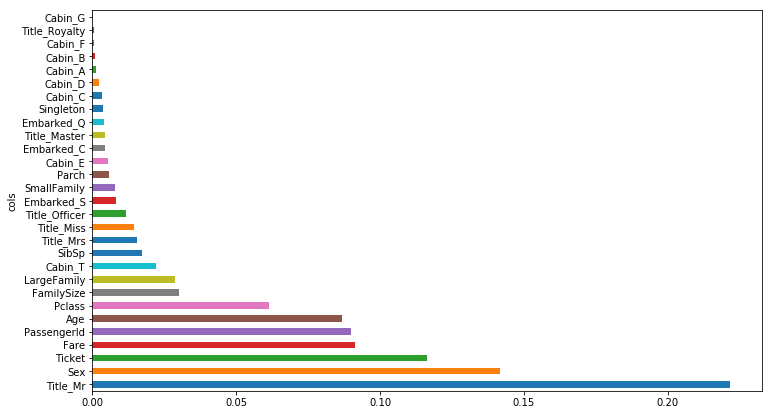

In [55]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);

In [56]:
# Keeping only the variables which are significant for the model(>0.01)
to_keep = fi[fi.imp>0.01].cols; len(to_keep)
to_keep

14

25         Title_Mr
6               Sex
7            Ticket
3              Fare
4       PassengerId
0               Age
5            Pclass
8        FamilySize
11      LargeFamily
22          Cabin_T
2             SibSp
26        Title_Mrs
24       Title_Miss
27    Title_Officer
Name: cols, dtype: object

#### Final Model

In [57]:
#Now training the model on the entire data with only the important features.
x_train = x_train[to_keep]
x_train

,Title_Mr,Sex,Ticket,Fare,PassengerId,Age,Pclass,FamilySize,LargeFamily,Cabin_T,SibSp,Title_Mrs,Title_Miss,Title_Officer
0,1,2,524,7.2500,1,22.0,3,2,0,1,1,0,0,0
1,0,1,597,71.2833,2,38.0,1,2,0,0,1,1,0,0
2,0,1,670,7.9250,3,26.0,3,1,0,1,0,0,1,0
3,0,1,50,53.1000,4,35.0,1,2,0,0,1,1,0,0
4,1,2,473,8.0500,5,35.0,3,1,0,1,0,0,0,0
5,1,2,276,8.4583,6,26.0,3,1,0,1,0,0,0,0
6,1,2,86,51.8625,7,54.0,1,1,0,0,0,0,0,0
7,0,2,396,21.0750,8,2.0,3,5,1,1,3,0,0,0
8,0,1,345,11.1333,9,27.0,3,3,0,1,0,1,0,0
9,0,1,133,30.0708,10,14.0,2,2,0,1,1,1,0,0


In [58]:
m = RandomForestClassifier(n_estimators=200,min_samples_leaf=3,max_features=0.5,n_jobs=-1)
m.fit(x_train,y_train)
m.score(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

0.936026936026936

In [59]:
x_test = x_test[to_keep]
output=m.predict(x_test).astype(int)

In [60]:
output.size

418